<a href="https://colab.research.google.com/github/drscook/MathVGerrmandering_CMAT_2022/blob/main/get_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mathematical Association of America - Texas Section
# 2022 Annual Meeting
# Workshop on Mathematical Tools to Fight Gerrymandering
# Part II - Getting and Preparing Data

### Time, Date, & Location
**March 31, 2022, 7:00pm - 9:00pm - revised June 14, 2022**

**University of North Texas Gateway Center, Gateway 42, Denton, TX**

Wifi connection is on the back of your nametag.

Zoom link: https://unt.zoom.us/j/83519091082

GitHub Repo: https://github.com/drscook/Redistricting_Workshop_MAA_TX_2022

Video: https://youtu.be/a0zgVTTcFiQ

Revision corrects bug caused by duplicated column names in the 2020 Census files leading to incorrect total population.

### Contributors

Workshop Facilitators:
- Dr. Scott Cook<sup>4</sup>
- Jaryd Domine<sup>3</sup>
- Cody Drolet<sup>4</sup>
- Dr. Will Hager<sup>5</sup>
- Mason McCallum<sup>3</sup>
- Dr. Betseygail Rand<sup>5</sup>
- Vianey Rangel<sup>4</sup>

Part I notebook contributors:
- Dr. Scott Cook<sup>4</sup>
- Diana Dinh-Andrus<sup>3</sup>
- Dr. Will Hager<sup>5</sup>
- Anthony Pizzimenti<sup>2</sup>
- Casey Sutton<sup>4</sup>
- Maria Tovar<sup>4</sup>
- Preston Ward<sup>4</sup>

Part II notebook contributors:
- Dr. Scott Cook<sup>4</sup>

Special Thanks:
- Metric Geometry & Gerrymandering Group
    - Dr. Moon Duchin<sup>6</sup>
- Math For Unbiased Maps Texas
    - Dr. Andrea Barreiro<sup>3</sup>
    - Dr. Matt Lockard<sup>3</sup>
    - Dr. Scott Norris<sup>3</sup>
    - Robert Meyers
    - Dr. Dustin Potter<sup>1</sup>
    - Dr. Brandi Stigler<sup>3</sup>


<sup>1</sup>Collin College, <sup>2</sup>Iowa State Univ, <sup>3</sup>Southern Methodist Univ, <sup>4</sup>Tarleton State Univ, <sup>5</sup>Texas Lutheran State Univ, <sup>6</sup>Tufts Univ

Ensemble analysis of electorial districting plans consists of several steps:
1. Get data - Retrieve, prepare, and combine geographic, demographic, and electoral data and assemble into a single dataset
2. Generate ensemble - Feed this dataset into tools like GerryChain to generate an ensemble of districting plans
3. Analyze - Statistically compare a proposed/enacted plan against the ensemble

Part I of this workshop focuses on steps 2 & 3 and assumes step 1 has already been completed.  Steps 2 & 3 are more interesting and satisfying mathematically and politically.  Step 1 is more tedious and requires more complex code, but is essential if you aim to do something beyond the scope of the dataset we provided.

Part II focuses on step 1 - retrieving, preparing, and combining data.  We will probably not discuss every line of code, but we'll hit as many highlights as time allows.

# Install & Import Packages and define helper functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! pip install --upgrade us mechanicalsoup geopandas pandas_bokeh

In [ ]:
%load_ext google.colab.data_table
import os, warnings, us, pathlib, mechanicalsoup, numpy as np, pandas as pd, geopandas as gpd, pandas_bokeh

# adjust the path below for your desired location
root_path = pathlib.Path('/content/drive/MyDrive/gerrymandering/summer2022')
pandas_bokeh.output_notebook()

parquet = {var: root_path / f'data/{var}/final.parquet' for var in
              ['census', 'shapes', 'assignments', 'elections', 'plans', 'blk', 'vtd']}
dfs = dict()

state = us.states.TX
print(state.fips, state.name, state.abbr)

# See below for introduction to CRS
meters_per_mile = 1609.34
crs = {
    'census': 'EPSG:4269'  , # degrees - used by Census
    'area'  : 'ESRI:102003', # meters
    'length': 'ESRI:102005', # meters
}

def read_existing(var):
    """try to read existing parquet file, return path to raw data if fail"""
    try:
        dfs[var] = gpd.read_parquet(parquet[var])
    except:
        try:
            dfs[var] = pd.read_parquet(parquet[var])
        except:
            path = parquet[var].parent
            path.mkdir(exist_ok=True, parents=True)
            return path
    return None

def download(file, url):
    """Help download data from internet sources"""
    if not file.is_file():  # check if file already exists
        print(f'downloading {file} from {url}')
        os.system(f'wget -O {file} {url}')
    print(f'unzipping {file}')  # unzip
    os.system(f'unzip -n {file} -d {file.parent}')

def to_numeric(ser):
    if ser.dtype != 'geometry':
        ser = pd.to_numeric(ser, errors='ignore', downcast='integer')  # cast to numeric datatypes where possible
    return ser

def prep(df):
    """prep dataframes"""
    c = len(df.index.names)
    df.reset_index(inplace=True)
    df.columns = [str(x).lower().strip() for x in df.columns]  # lower case column names
    df = df.apply(to_numeric)
    idx = df.columns[:c].tolist()
    return df.set_index(idx)

# Fetch Data

## Data Sources
* US Census Bureau
  * Shapes
  * 2020 Decennial Census
  * Block Assignment Files
* Texas Legislative Council
  * Election results
  * Voting Tabulation Districts (VTD)

## 2020 Decennial Census Data

* https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html
* https://www2.census.gov/programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/
* https://data.census.gov/cedsci/all?q=&y=2020&d=DEC%20Redistricting%20Data%20%28PL%2094-171%29

Download the redistricting dataset from the Census Bureau mandated by Congress in 1975 in [Public Law (PL) 94-171](https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html) which consists of 6 separate files.  For the sake of time, just get P1 & P2 now.
* Go to [Data Explorer](https://data.census.gov/cedsci/table?q=&y=2020&d=DEC%20Redistricting%20Data%20%28PL%2094-171%29&tid=DECENNIALPL2020.P1)
* Geos = "Block" in Texas, All Blocks in Texas
* Download whatever sets(s) you want P1, P2, P3, P4, P5, H1.  I suggest 1 at a time.
    * Note P1 & P3 except the P3 counts only voting-age population.  They have the same column names and may conflict with each other.  I suggest you decide in advance whether you want ALL population or just VAP and only use the corresponding file.  Same for P2 & P4.  
* MAY NEED TO ALLOW POP UPS
* Upload into folder "census"

### Screenshots

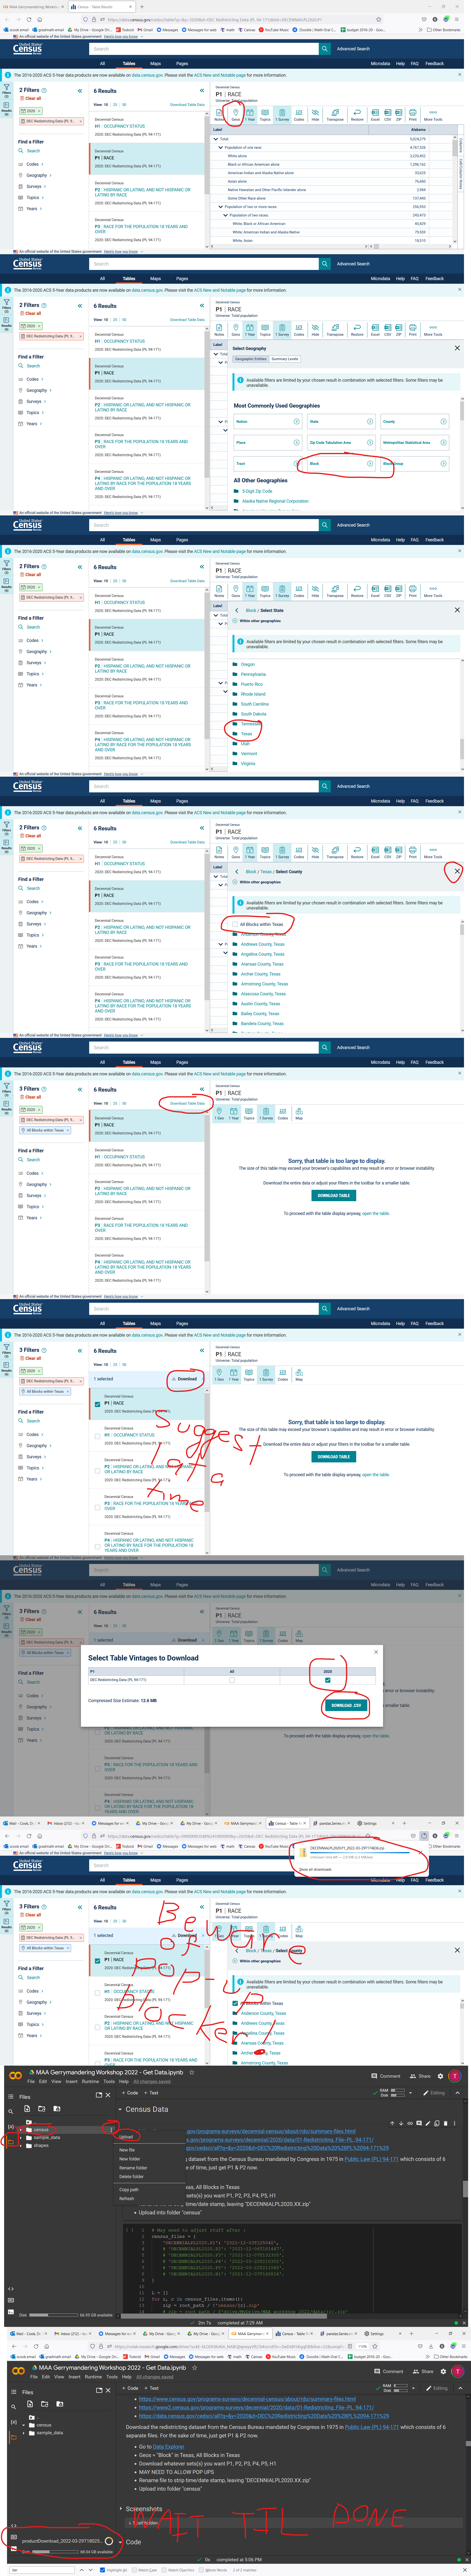

### Code

In [ ]:
var = 'census'
path = read_existing(var)
if path:  # final parquet file not found - fetch from source
    # unzip all zip files
    for file in path.iterdir():
        if file.suffix == '.zip':
            os.system(f'unzip -n {file} -d {path}')

    # find & read relevant files (name contains "overlays")
    L = []
    for file in sorted(path.iterdir()):
        if 'overlays' in file.name:
            df = prep(pd.read_csv(file, skiprows=1)).drop(columns='geographic area name')  # read file
            df['id'] = df['id'].str.split('US', expand=True)[1].astype(int)  # extract geoid from longer id

            # rename columns to user-friendly versions, set index, select relevant columns
            repl = {x: x.replace('!!','').replace('total:','').strip(' :') for x in df.columns}
            repl['!!total:'] = 'total'
            tbl = file.stem.split('.')[1][:2]
            repl = {key: tbl+':'+val for key, val in repl.items()}
            repl['id'] = 'geoid'
            
            df = df.rename(columns=repl).set_index('geoid')
            L.append(df)  # append to list
    try:
        dfs[var] = prep(pd.concat(L, axis=1))  # remove duplicate columns
        del L
        dfs[var].insert(0, 'pop', dfs[var]['p1:total'])
    except ValueError:
        raise Exception('You probably forgot to upload the zip file(s) into the "census" folder')
    dfs[var].to_parquet(parquet[var])


## Shapes

* https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf
* https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
* https://www2.census.gov/geo/tiger/TIGER2020/

The Census Bureau decomposes the US into increasingly fine partitions as seen in the [geodiagram](https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf).  While most Census datasets have limited resolution, the decennial census is among the few available at the block-level (lowest).  Thus, we work at this lowest level as much as possible, and aggegrate up at the end.

In [ ]:
var = 'shapes'
path = read_existing(var)
if path:  # final parquet file not found - fetch from source
    file = path / f'tl_2020_{state.fips}_tabblock20.zip'
    url = f'https://www2.census.gov/geo/tiger/TIGER2020/TABBLOCK20/{file.name}'
    download(file, url)

    num_rows = None
    df = prep(gpd.read_file(file, rows=num_rows))  # read file
    # rename columns to user-friendly versions, set index, select relevant columns
    repl = {x: x.replace('20','') for x in df.columns}
    dfs[var] = prep(df.rename(columns=repl).set_index('geoid')[['aland', 'geometry']])
    del df
    dfs[var].to_parquet(parquet[var])

## Block Assignment Files

* https://www.census.gov/geographies/reference-files/time-series/geo/block-assignment-files.html
* https://www2.census.gov/geo/docs/maps-data/data/baf2020/

Block assignment files connect block ids to congressional, TX Senate, TX House, voting tabulation, and other districts of interest.

For vtds, we must take an extra formatting step so the Census data properly joins to the TX Lege data.  See discussion under "Elections".

In [ ]:
var = 'assignments'
path = read_existing(var)
if path:  # final parquet file not found - fetch from source
    file = path / f'BlockAssign_ST{state.fips}_{state.abbr}.zip'
    url = f'https://www2.census.gov/geo/docs/maps-data/data/baf2020/{file.name}'
    download(file, url)

    L = []
    d = {'VTD':'vtd', 'CD':'congress2010', 'SLDU':'senate2010', 'SLDL':'house2010'}
    for abbr, name in d.items():
        f = path / f'{file.stem}_{abbr}.txt'
        print(f'reading block → {name} assignments from {f}')
        df = prep(pd.read_csv(f, sep='|'))
        if name == 'vtd':
            # create vtd id using 3 fips + 6 vtd, pad on left with 0 as needed
            df['district'] = df['countyfp'].astype(str).str.rjust(3, '0') + df['district'].str.rjust(6, '0')
        # rename columns to user-friendly versions, set index, select relevant columns
        repl = {'blockid': 'geoid', 'district': name}
        df = df.rename(columns=repl).set_index('geoid')[[name]]
        L.append(df)  # append to list
    dfs[var] = prep(pd.concat(L, axis=1))  # concat into single dataframe
    dfs[var]['fips'] = dfs[var].index // 10000000000
    del L
    dfs[var].to_parquet(parquet[var])

## Elections

* https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf
* https://data.capitol.texas.gov/dataset/vtds
* https://data.capitol.texas.gov/dataset/comprehensive-election-datasets-compressed-format

Observe in the [geodiagram](https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf) that "Voting Districts" are NOT controlled by the Census Bureau. They are controlled by states.  So, these shapes do NOT always respect Census block boundaries; Texas *precincts* are an example.

However, the Texas Legistlative Council (TX Lege) creates [*voting tabulation districts (VTD)*](https://data.capitol.texas.gov/dataset/vtds): "...census geographic equivalent of county election precincts, are created for the purpose of relating 2020 Census population data to election precinct data."  TLC releases [historical election results using VTDs](https://data.capitol.texas.gov/dataset/comprehensive-election-datasets-compressed-format).

In [ ]:
var = 'elections'
path = read_existing(var)
if path:  # final parquet file not found - fetch from source
    file = path / f'2020-general-vtd-election-data-2020.zip'
    url = f'https://data.capitol.texas.gov/dataset/35b16aee-0bb0-4866-b1ec-859f1f044241/resource/5af9f5e2-ca14-4e5d-880e-3c3cd891d3ed/download/{file.name}'
    download(file, url)

    L = []
    for f in sorted(path.iterdir()):
        a = f.stem.split('_')
        if a[-1] == 'Returns':
            df = prep(pd.read_csv(f)).query('votes > 0 & party in ["R", "D", "L", "G"]').copy()
            df['race'] = '_'.join(a[:-2]) + '_' + df['office'] + '_' + df['name'] + '_' + df['party']
            # df['incumbent'] = df['incumbent'] == 'Y'
            df['fips'] = df['fips'].astype(str)
            df['v']  = df['vtd'].astype(str)
            df['votes']  = df['votes'].astype(int)
            df = df[['fips', 'v', 'county', 'race', 'votes']]
            L.append(df)
    df = pd.concat(L)
    del L
    
    # format to match census
    df['fips']    = '48' + df['fips'].str.rjust(3, '0')
    df['vtd']     = df['fips'].str[2:] + df['v'].str.rjust(6, '0')
    df['vtd_alt'] = df['fips'].str[2:] + df['v'].str[:-1].str.rjust(6, '0')
    
    all_vtds = np.unique(dfs['assignments']['vtd'])
    mask = ~df['vtd'].isin(all_vtds)
    print(f'{mask.sum()} election rows do not match census - using alternate')

    df.loc[mask, 'vtd'] = df.loc[mask, 'vtd_alt']
    mask = ~df['vtd'].isin(all_vtds)
    lost_votes = df.loc[mask, 'votes'].sum()
    total_votes = df['votes'].sum()
    print(f'{mask.sum()} election rows still do not match census - dropping {lost_votes} of {total_votes} votes')

    df_long = df[~mask].groupby(['vtd', 'fips', 'county', 'race'])['votes'].sum()
    del df
    dfs[var] = prep(df_long.unstack('race').fillna(0).astype(int).reset_index().set_index('vtd'))
    del df_long
    dfs[var].to_parquet(parquet[var])

counties = dfs['elections'][['fips', 'county']].dropna().drop_duplicates().set_index('fips')
dfs['elections'].drop(columns=['fips', 'county'], inplace=True)

One tedious obstacle is that the vtd identifiers used by the TX Lege and the US Census do not perfectly match.  Thus, we must do some delicate formatting
* vtd ids must be 9 characters
  * first 3 are county fips code
  * last 6 denote vtd
* if number is shorter, we pad on left with 0's
* leaves about 77,000 rows of election data that do not match Census
* I discovered a trick that fixes almost all of these orphans:
  * drop the last character of the TX Lege identifier
  * only remaining orphaned votes come from county 113 (Dallas) vtd 3114 in 2020
  * I believe this vtd was created very recently and is not yet in the Census data
  * vanishingly small number of votes (2 in each race)



## Districting Plans*
(added after MAA workshop)

* https://data.capitol.texas.gov/organization/tlc

All of the plans that were proposed to the Texas Redistricting Committees in Fall 2021 are posted on the TX Legislative Council data portal (above).  We specifically need the block equivalency files, which have a unique resource id that is tricky to get automatically.  The code below uses mechanicalsoup to attempt to retrieve these urls automatically.

Many proposals were modifications of other plans and are not complete in their own respect.  This code attempts to filter them out.

In [ ]:
var = 'plans'
path = read_existing(var)
if path:  # final parquet file not found - fetch from source
    browser = mechanicalsoup.Browser()
    district_types = {'s':31, 'h':150, 'c':38}
    for dt in district_types.keys():
        not_found = 0
        for k in range(1000):
            not_found += 1
            proposal = f'plan{dt}{2100+k}'.lower()
            root_url = f'https://data.capitol.texas.gov/dataset/{proposal}#'
            login_page = browser.get(root_url)
            tag = login_page.soup.select('a')
            if len(tag) >= 10:
                not_found = 0
                for t in tag:
                    url = t['href']
                    if 'blk.zip' in url:
                        file = path / url.split('/')[-1]
                        if not file.is_file():
                            download(file, url)
            if not_found > 15:
                break

    for file in path.iterdir():
        if file.suffix == '.zip':
            os.system(f'unzip -n {file} -d {path}')

    L = []
    for file in path.iterdir():
        if file.suffix == '.csv':
            plan = file.stem.lower()
            dt = plan[4]
            df = pd.read_csv(file)
            df.columns = ['geoid', plan]
            if df[plan].nunique() == district_types[dt]:
                L.append(df.set_index('geoid'))
    dfs[var] = prep(pd.concat(L, axis=1))
    del L
    dfs[var].to_parquet(parquet[var])

# Combine Data & Aggregate to VTD

In [ ]:
def last_step(var):
    head = ['fips', 'county', 'pop', 'density', 'polsby_popper', 'aland', 'perim']
    tail = ['geometry']
    df = dfs[var]
    df = df.join(counties, on='fips')
    df.geometry = df.geometry.to_crs(crs['length'])
    df['perim'] = df.length
    df['area']  = df.area
    df['polsby_popper'] = 4*np.pi*df['area'] / (df['perim']**2)
    df['density'] = df['pop'] / df['area']
    L = head + [x for x in df.columns if x not in head+tail] + tail
    dfs[var] = prep(df[L].fillna(0))
    dfs[var].to_parquet(parquet[var])

In [ ]:
# combine everything at the block level
var = 'blk'
path = read_existing(var)
if path:  # final parquet file not found - fetch from source
    dfs[var] = dfs['shapes'].join(dfs['assignments']).join(dfs['plans']).join(dfs['census'])
    last_step(var)
try:
    del dfs['shapes'], dfs['assignments'], dfs['plans'], dfs['census']
except:
    pass

Coordinate reference systems (CRS) play a central role in geospatial applications.  We know the famliar Mercator projection of the earth wildly distorts relative areas.  In truth, every projection of round onto flat is wrong.  But a well-chosen CRS gives right answers in the places and attributes that matter for that situation.

Above, we defined a dictionary called "crs" with 3 options that are helpful for our purposes.

In [ ]:
# aggregate to VTD level
var = 'vtd'
path = read_existing(var)
if path:  # final parquet file not found - fetch from source
    # data aggregation
    # drop for aggegration
    drop      = ['geometry', 'geoid', 'vtd', 'county']
    # aggegrate using most populuous value - see function below
    mode_cols = ['fips', 'congress2010', 'senate2010', 'house2010'] + [x for x in dfs['blk'].columns if x[:4] == 'plan']
    # aggegrate using sum
    sum_cols  = [x for x in dfs['blk'].columns if not x in drop+mode_cols]  # aggegrate using sum

    def mode(df, district):
        """For each vtd, find the district which contains the maximal population.
        Ex: Suppose a vtd consists of some blocks in district A, other blocks in district B,
        and still others in district C.  Compute total population in these three
        sets of blocks and assign the vtd to the district with highest."""
        intersect_pop =  df.groupby(['vtd', district])[['pop']].sum()  # pop in intersect of each (vtd, district) pair
        intersect_pop['M'] = intersect_pop.groupby('vtd')['pop'].transform('max')  # max intersect_pop over all districts for each vtd
        M = intersect_pop.query('pop == M')  # select only rows that attain max intersect_pop within its vtd
        M = M.groupby('vtd').head(1)  # in case of a tie, select the first one
        return M.reset_index(district)[district]  # drop intermediate calculations, return only vtd & district

    L = []
    for col in mode_cols:
        df = mode(dfs['blk'], col)
        L.append(df)

    for col in sum_cols:
        df = dfs['blk'].groupby('vtd')[col].sum()
        L.append(df)
    data = pd.concat(L, axis=1)
    del L

    # geospatial aggegration
    geo = dfs['blk'][['geometry', 'vtd']].dissolve(by='vtd')

    # join aggegrated vtd shapes & data and bring election data
    dfs[var] = geo.join(data).join(dfs['elections'])
    del geo, data
    last_step(var)
# try:
#     del dfs['elections']
# except:
#     pass

# Use

In [ ]:
vtd_df = gpd.read_parquet(root_path / 'data/vtd/final.parquet')

# simplify polygon boundaries so choropleth renders fast with reasonable file size
vtd_df = simplify(vtd_df, 100)

# round to make hover tool easier to read
vtd_df['density'] = vtd_df['density'].fillna(0).astype(int)
vtd_df['polsby_popper'] = (vtd_df['polsby_popper'] * 100).astype(int)

NameError: ignored

In [ ]:
def simplify(gdf, meters=-1):
    if meters >= 0:
        gdf.geometry = (
            gdf.geometry
            .to_crs(crs['length'])
            .buffer(0)
            .simplify(meters)
            .to_crs(crs['census'])
        )
    return gdf

def choropleth(gdf, file=None, **kwargs):
    """Draw choropleth map from geopandas dataframe using pandas bokeh"""
    opts = {
        'category': 'plans2168',
        'hovertool_columns': ['vtd', 'county', 'pop', 'density', 'polsby_popper', 'aland'],
        'colormap': 'Paired',
        'line_alpha': 0.1,
        'fill_alpha': 1.0,
        'xlim': [-106.2, -94.0],
        'ylim': [ 25.4 ,  36.6],
        'return_html': True,
        'show_figure': True,
        'show_colorbar': False,
    }
    opts.update(kwargs)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig = gdf.reset_index().plot_bokeh(**opts)
    
    if file is not None:
        with open(file.with_suffix('.html'), 'w') as f:
            print(f'exporting image to {f.name}')
            f.write(fig)
choropleth(vtd_df, file=root_path/'map')

In [ ]:
# Find VTD's with non-zero population but NO election results
mask = (vtd_df['pop'] > 0) & (vtd_df[dfs['elections'].columns].sum(axis=1)==0)
missing = vtd_df[mask].sort_values('pop', ascending=False)
choropleth(missing, tile_alpha=0.8, category=None)
display(missing)